# BNMPy Optimizer Example

This notebook demonstrates how to use the BNMPy optimizer for parameter estimation in Probabilistic Boolean Networks (PBNs).

In [2]:
import sys
import numpy as np
import pandas as pd
import time
sys.path.append('../src')
from Optimizer.parameter_optimizer import ParameterOptimizer
from BNMPy import PBN, BMatrix

## Simple Example: Three-Node Network

In [3]:
# Define PBN rules with initial probabilities
rules = """
N1 = N1, 1
N2 = N2, 1
N3 = N1, 0.5
N3 = N1 & !N2, 0.5
"""

# Load PBN
pbn = BMatrix.load_pbn_from_string(rules)

No initial state provided, using a random initial state


### Create Experimental Data

Synthetic experimental data for testing.
Obtained from this network:  
  
N1 = N1, 1  
N2 = N2, 1  
N3 = N1, 0.6  
N3 = N1 & !N2, 0.4  

In [3]:
# Create experimental data
experiments = pd.DataFrame({
    'Experiments': [1, 2, 3],
    'Stimuli': ['', 'N1,N2', 'N1'],
    'Inhibitors': ['', '', 'N2'],
    'Measured_nodes': ['N3', 'N3', 'N3'],
    'Measured_values': ['0.4', '0.6', '1']
})

experiments.to_csv('experiments.csv', index=False)

## Differntial Evolution Optimization

In [4]:
# Configure optimizer
config = {
    'de_params': {
        'strategy': 'best1bin',
        'maxiter': 50,
        'popsize': 15,
        'tol': 0.01,
        'mutation': (0.5, 1),
        'recombination': 0.7,
        'init': 'sobol',
        'updating': 'deferred',
        'workers': -1, # Use all available cores for parallelization
        'polish': False  # Disable polish step for faster runs
    },
    'steady_state': {
        'method': 'monte_carlo',
        'monte_carlo_params': {
            'n_runs': 5, 
            'n_steps': 500,
            'p_noise': 0.05
        },
    },
    'max_try': 3,  # Maximum number of attempts if optimization fails
    'early_stopping': True,  # Control early stopping for both DE and PSO
    'success_threshold': 2e-3
}

In [5]:
# Initialize optimizer
optimizer = ParameterOptimizer(pbn, 'experiments.csv', config=config, nodes_to_optimize=['N3'], verbose=False)

# Run optimization and time it
start_time = time.time()
result = optimizer.optimize(method='differential_evolution')
end_time = time.time()
print(f"Optimization took {end_time - start_time:.2f} seconds")


Running optimization using method: differential_evolution
Maximum attempts: 3

--- Attempt 1/3 ---
[███████░░░░░░░░░░░░░░░░░░░░░░░] 26.0% | Iter: 13/50 | Best SSE: 0.001940 | Conv: 0.0438

Successful optimization found in attempt 1
  - SSE: 0.001539

--- Optimization finished. Best SSE found: 0.001539 ---

--- Optimized PBN Rules ---
N1 = N1, 1.0000
N2 = N2, 1.0000
N3 = N1, 0.5937
N3 = N1 & !N2, 0.4063
---------------------------

Optimization took 2.57 seconds


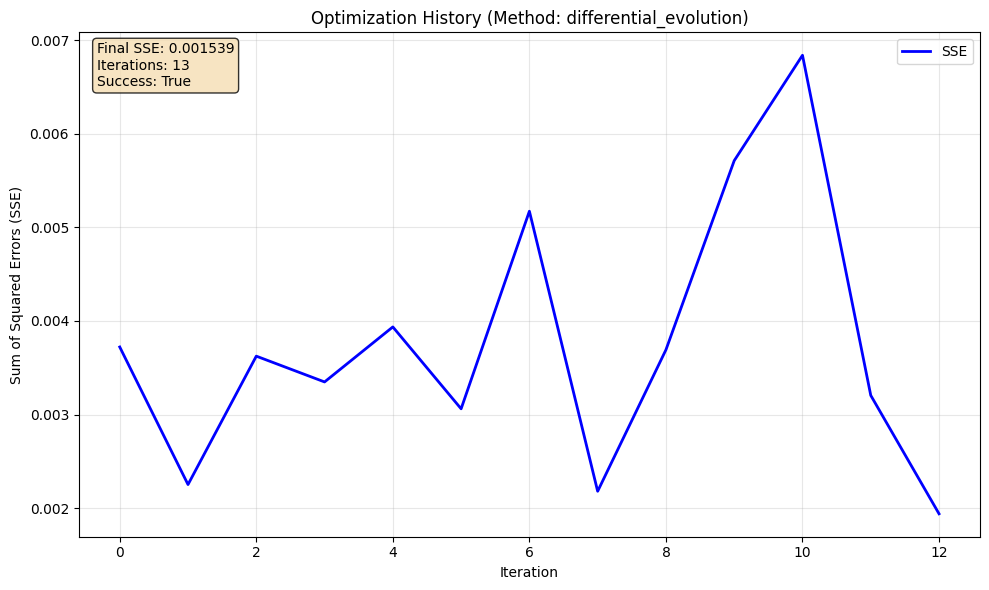

In [6]:
optimizer.plot_optimization_history(result)

In [7]:
print(optimizer.get_pbn_rules_string())

N1 = N1, 1.0000
N2 = N2, 1.0000
N3 = N1, 0.5937
N3 = N1 & !N2, 0.4063


In [7]:
# Get optimized PBN
optimized_pbn = optimizer.get_optimized_pbn(result)

# Run simulation with optimized parameters
optimized_pbn.setInitialValues([1, 1, 0])  # Set initial state
trajectory = optimized_pbn.update(10)  # Run for 10 steps

print("Simulation with optimized parameters:")
print(trajectory)

Simulation with optimized parameters:
[[1 1 0]
 [1 1 1]
 [1 1 1]
 [1 1 0]
 [1 1 0]
 [1 1 1]
 [1 1 1]
 [1 1 0]
 [1 1 0]
 [1 1 1]
 [1 1 1]]


## Particle Swarm Optimization

In [ ]:
# Configure optimizer
config = {
    'pso_params': {
        'n_particles': 30,
        'iters': 100,
        'options': {'c1': 0.5, 'c2': 0.3, 'w': 0.9},
        'ftol': 1e-4,  # Function tolerance for early stopping
        'ftol_iter': 10  # Number of iterations to check for stagnation
    },
    'steady_state': {
        'method': 'monte_carlo',
        'monte_carlo_params': {
            'n_runs': 5, 
            'n_steps': 500,
            'p_noise': 0.05
        },
    },
    'max_try': 3,  # Maximum number of attempts if optimization fails
    'early_stopping': True  # Control early stopping for both DE and PSO
}

In [9]:
# Initialize optimizer
optimizer = ParameterOptimizer(pbn, 'experiments.csv', config=config, nodes_to_optimize=['N3'], verbose=False)

# Run optimization
result = optimizer.optimize(method='particle_swarm')

2025-06-22 17:21:14,567 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Running optimization using method: particle_swarm
Maximum attempts: 3

--- Attempt 1/3 ---


pyswarms.single.global_best:  13%|█▎        |13/100, best_cost=0.00138
2025-06-22 17:21:27,640 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0013812160957872646, best pos: [0.77674773 0.56321212]



Successful optimization found in attempt 1
  - SSE: 0.001381

--- Optimization finished. Best SSE found: 0.001381 ---

--- Optimized PBN Rules ---
N1 = N1, 1.0000
N2 = N2, 1.0000
N3 = N1, 0.5797
N3 = N1 & !N2, 0.4203
---------------------------



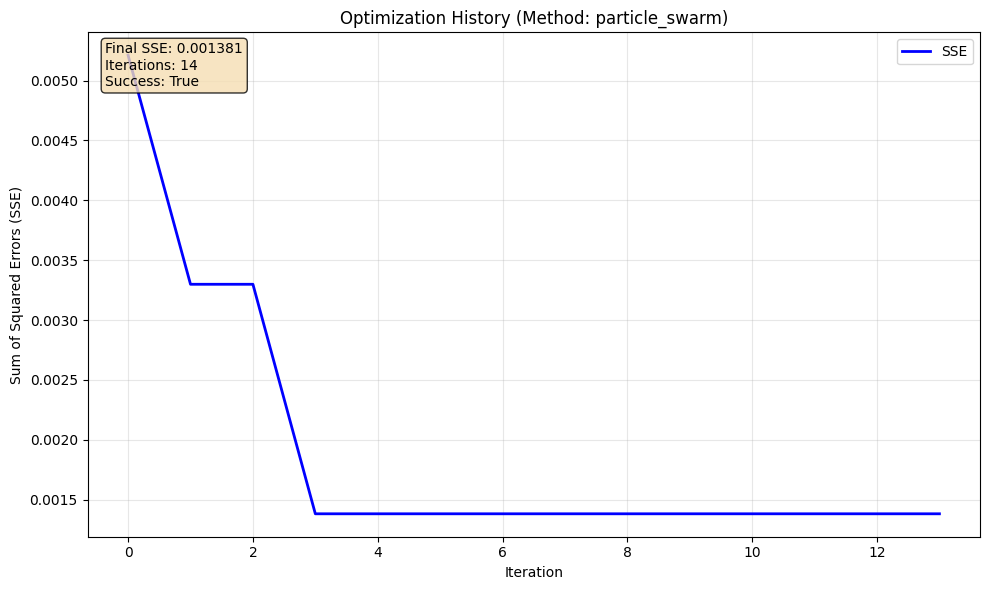

In [10]:
optimizer.plot_optimization_history(result)

## Discrete Mode Optimization

Now let's try optimizing for a Boolean Network (discrete mode).
  
Synthetic experimental data obtained from this network:  
  
N1 = N1, 1  
N2 = N2, 1  
N3 = N1, 0.9  
N3 = N1 & !N2, 0.1  

In [8]:
experiments_discrete = pd.DataFrame({
    'Experiments': [1, 2, 3],
    'Stimuli': ['', 'N1,N2', 'N1'],
    'Inhibitors': ['', '', 'N2'],
    'Measured_nodes': ['N3', 'N3', 'N3'],
    'Measured_values': ['0.475', '0.9', '1']
})
experiments_discrete.to_csv('experiments_discrete.csv', index=False)

In [11]:
# Initialize optimizer with discrete config
discrete_config = config.copy()
discrete_config['discrete_params']['threshold'] = 0.6
discrete_optimizer = ParameterOptimizer(pbn, 'experiments_discrete.csv', config=discrete_config, nodes_to_optimize=['N3'], discrete=True)

# Run optimization in discrete mode using DE
discrete_result = discrete_optimizer.optimize(
    method='differential_evolution'
)


Running optimization using method: differential_evolution
Maximum attempts: 3

--- Attempt 1/3 ---
[██░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 8.0% | Iter: 4/50 | Best SSE: 0.001727 | Conv: 0.0085
Optimization attempt 1 did not succeed: callback function requested stop early (SSE: 0.002235)
An error occurred during optimization attempt 1: cannot access local variable 'best_score' where it is not associated with a value

--- Attempt 2/3 ---
[█████░░░░░░░░░░░░░░░░░░░░░░░░░] 18.0% | Iter: 9/50 | Best SSE: 0.001509 | Conv: 0.0231

Successful optimization found in attempt 2
  - SSE: 0.001623

--- Optimization finished. Best SSE found: 0.001623 ---

Discretizing final parameters...

Discretized Selection Probabilities:
[[ 1. -1.]
 [ 1. -1.]
 [ 1.  0.]]

--- Optimized PBN Rules ---
N1 = N1, 1.0000
N2 = N2, 1.0000
N3 = N1, 1.0000
---------------------------



In [12]:
print(optimizer.get_pbn_rules_string())

N1 = N1, 1.0000
N2 = N2, 1.0000
N3 = N1, 1.0000
